### Onset Detection


Inspired by https://www.ofai.at/~jan.schlueter/pubs/2014_icassp.pdf

In [9]:
import numpy as np
import torch as th
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchaudio

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import glob
from os import path
import pickle

import models
import data

In [2]:
th.manual_seed(42)
np.random.seed(42)

#### DATA

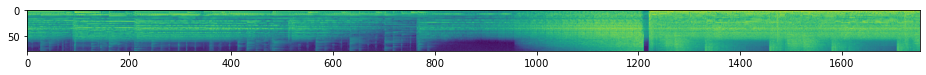

torch.Size([3, 80, 15]) torch.Size([15])


In [3]:
waveform, sample_rate = torchaudio.load('data/train/ff123_Blackwater.wav', normalize=True)

mel_specgram = data.mel(waveform[0], sample_rate)
plt.figure(figsize=(16,16))
plt.imshow(mel_specgram[0])
plt.show()

onsets = data.load_onsets('data/train/ff123_Blackwater.onsets.gt')
y = data.make_target(onsets, mel_specgram.shape[-1], sample_rate)

X_frames, y_frames = data.make_frames(mel_specgram, y, onsets, sample_rate)

print(X_frames[0].shape, y_frames[0].shape)

In [4]:
def visualize_sample(idx):
    print(y_frames[idx])
    for i in range(3):
        plt.imshow(X_frames[idx][i])
        plt.show()

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 1.0000, 0.2500, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


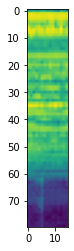

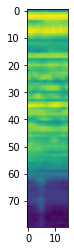

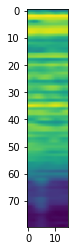

In [5]:
visualize_sample(2)

In [3]:
train_path = 'data/train_onsets'
X_files = glob.glob(path.join(train_path, '*.wav'))
y_files = glob.glob(path.join(train_path, '*.onsets.gt'))
print(len(X_files))

X_files_train, X_files_test, y_files_train, y_files_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
print(len(X_files_train), len(X_files_test))

277
221 56


In [4]:
X_train, sample_rates_train = data.preprocess_audio(X_files_train)
onsets_train = [data.load_onsets(path) for path in y_files_train]
y_train = [data.make_target(onsets_train[i], X_train[i].shape[-1], sample_rates_train[i]) for i in range(len(onsets_train))]

100%|██████████| 221/221 [00:25<00:00,  8.74it/s]


In [5]:
X_test, sample_rates_test = data.preprocess_audio(X_files_test)
onsets_test = [data.load_onsets(path) for path in y_files_test]

100%|██████████| 56/56 [00:06<00:00,  8.01it/s]


In [11]:
dataset = data.AudioOnsetDataset(X_train, sample_rates_train, y_train, onsets_train)

with open('dataset-stats.pkl', 'wb') as f:
    pickle.dump({ 'mean': dataset.mean, 'std': dataset.std }, f)

####  TRAINING

In [16]:
epochs = 100
device = 'cuda' if th.cuda.is_available() else 'cpu'
lr = 3e-4

train_dataloader = DataLoader(dataset, shuffle=True, batch_size=256)

In [20]:
model = models.Resi(3).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

pos_weight = th.Tensor([14.]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

data_mean, data_std = dataset.mean.to(device), dataset.std.to(device)

best_mean = 0
for epoch in range(epochs):
    model.train()
    print(f'epoch {epoch + 1}')
    
    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        
        # fuzzy weight mask
        mask = th.ones_like(y)
        mask[y == 0.25] = 0.25
        y[y == 0.25] = 1.
        
        out = model(X)
        loss = F.binary_cross_entropy_with_logits(out, y, weight=mask, pos_weight=pos_weight)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'loss: {loss.item()}')
            
    model.eval()
    f_scores_train = onsets.evaluate_onsets(model, X_train, onsets_train, data_mean, data_std)
    f_scores_test = onsets.evaluate_onsets(model, X_test, onsets_test, data_mean, data_std)
    f_mean_test = np.mean(f_scores_test)
    print(f'F-scores: TRAIN {np.mean(f_scores_train)} | TEST {np.mean(f_mean_test)}')
    
    if f_mean_test > best_mean:
        best_mean = f_mean_test
        th.save(model.state_dict(), 'resi.pt')

epoch 1
loss: 1.9494569301605225
loss: 0.8451339602470398
loss: 0.7960265874862671
loss: 0.6812805533409119
loss: 0.6573452949523926
loss: 0.6452043056488037
loss: 0.6128525137901306
loss: 0.6305066347122192
loss: 0.6171936988830566
loss: 0.7062654495239258
loss: 0.573901891708374
F-scores: TRAIN 0.8027036284220547 | TEST 0.806163170612473
epoch 2
loss: 0.5942018628120422
loss: 0.553197979927063
loss: 0.557220458984375
loss: 0.5234838724136353
loss: 0.5575026273727417
loss: 0.4965999126434326
loss: 0.5517811179161072
loss: 0.6017323136329651
loss: 0.5368268489837646
loss: 0.5387857556343079
loss: 0.5403133630752563
F-scores: TRAIN 0.7934619101077282 | TEST 0.792831959588666
epoch 3
loss: 0.5784621834754944
loss: 0.4662865102291107
loss: 0.48712795972824097
loss: 0.5065343379974365
loss: 0.5619780421257019
loss: 0.5358225703239441
loss: 0.5507742762565613
loss: 0.5303400158882141
loss: 0.4787066578865051
loss: 0.4387648403644562
loss: 0.5153872966766357
F-scores: TRAIN 0.818047879780714

loss: 0.35625460743904114
loss: 0.3712741434574127
loss: 0.36030369997024536
F-scores: TRAIN 0.8519926778708051 | TEST 0.8401705976529533
epoch 25
loss: 0.3759356439113617
loss: 0.355563759803772
loss: 0.39884060621261597
loss: 0.4040425717830658
loss: 0.4667969048023224
loss: 0.42124471068382263
loss: 0.37578877806663513
loss: 0.4097953140735626
loss: 0.357339084148407
loss: 0.4149380028247833
loss: 0.4280067980289459
F-scores: TRAIN 0.8502016324923516 | TEST 0.837731271159519
epoch 26
loss: 0.4090658724308014
loss: 0.42469027638435364
loss: 0.3395818769931793
loss: 0.4072284400463104
loss: 0.39795759320259094
loss: 0.3784196674823761
loss: 0.38658857345581055
loss: 0.36956048011779785
loss: 0.38495466113090515
loss: 0.37212297320365906
loss: 0.4619564712047577
F-scores: TRAIN 0.8549025037041954 | TEST 0.8375770841092623
epoch 27
loss: 0.43896499276161194
loss: 0.4038008451461792
loss: 0.3388124704360962
loss: 0.38772380352020264
loss: 0.35122644901275635
loss: 0.3942584991455078
loss

#### VISUALIZE

In [8]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
model = models.Resi(3)
model.load_state_dict(th.load('resi.pt'))
model.eval()
model = model.to(device)

In [9]:
X_files_test[:3]

['data/train_onsets\\ah_test_cello_03_CelloTaksimi_pt1.wav',
 'data/train_onsets\\gs_mix1_-5dB.wav',
 'data/train_onsets\\Media-106011(14.8-24.8).wav']

In [10]:
X_test, sample_rates_test = data.preprocess_audio(X_files_test[:3])
onsets_test = [data.load_onsets(path) for path in y_files_test[:3]]

100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


In [11]:
data_mean, data_std = dataset.mean.to(device), dataset.std.to(device)

X, target = X_test[2], onsets_test[2]

preds_smoothed = onsets.onset_signal(model, X, data_mean, data_std)

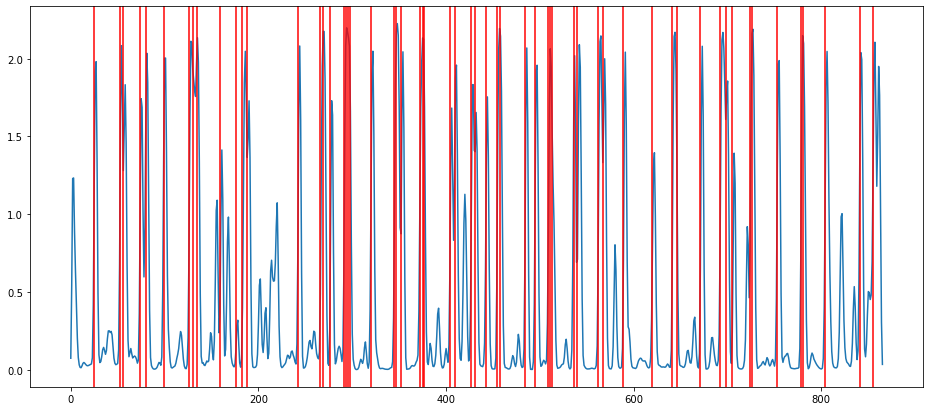

In [12]:
plt.figure(figsize=(16, 7))

plt.plot(preds_smoothed)

for x in target:
    x_t = int((x * data.SAMPLE_RATE) / data.HOP_LENGTH) # hop_length
    plt.axvline(x=x_t,color='red')
    
plt.show()